In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from collections import Counter
import nltk
import string
from nltk.corpus import stopwords 
from scipy.sparse import lil_matrix
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv('profiles.csv')

In [3]:
df.drinks.value_counts()

socially       41780
rarely          5957
often           5164
not at all      3267
very often       471
desperately      322
Name: drinks, dtype: int64

In [4]:
df.education.value_counts()

graduated from college/university    23959
graduated from masters program        8961
working on college/university         5712
working on masters program            1683
graduated from two-year college       1531
graduated from high school            1428
graduated from ph.d program           1272
graduated from law school             1122
working on two-year college           1074
dropped out of college/university      995
working on ph.d program                983
college/university                     801
graduated from space camp              657
dropped out of space camp              523
graduated from med school              446
working on space camp                  445
working on law school                  269
two-year college                       222
working on med school                  212
dropped out of two-year college        191
dropped out of masters program         140
masters program                        136
dropped out of ph.d program            127
dropped out

In [5]:
def zodiac(x): 
    if type(x) != str:
        return None
    if x[-5:] == 'about': 
        return 1 # cares a little bit 
    if x[-6:] == 'matter':
        return 0 # doesn't care at all
    if x[-3:] == 'lot': 
        return 2 # cares a lot 

def isAdvancedDegree(x): 
    if type(x) != str: 
        return None
    matches = ['ph.d', 'masters', 'law', 'space','med']
    if 'graduated' in x and any(i in x for i in matches): 
        return 1
    else: 
        return 0

def drugs(x): 
    if type(x) != str: 
        return None    
    if x == 'never': 
        return 0 
    if x == 'sometimes': 
        return 1 
    if x == 'often':
        return 2
    
def smoking(x): 
    if type(x) != str: 
        return None
    if 'no' in x: 
        return 0
    if 'sometimes' in x or 'when' in x:
        return 1 
    if 'yes' or 'trying': 
        return 2 

In [6]:
list(df.body_type.value_counts().index)

['average',
 'fit',
 'athletic',
 'thin',
 'curvy',
 'a little extra',
 'skinny',
 'full figured',
 'overweight',
 'jacked',
 'used up',
 'rather not say']

In [7]:
body_type_ohe = pd.get_dummies(df.body_type)
diet_ohe = pd.get_dummies(df.diet)
drinks_ohe = pd.get_dummies(df.drinks)
offspring_ohe = pd.get_dummies(df.offspring)
ohes = [body_type_ohe, diet_ohe, drinks_ohe, offspring_ohe]

In [8]:
df2 = df[['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'height', 'job', 'offspring', 'sign',
         'smokes']]

In [9]:
for o in ohes: 
    df2 = df2.join(o)

In [10]:
df2 = df2.drop(['body_type', 'diet', 'drinks', 'job', 'offspring'], axis=1)

In [11]:
df2['sign'] = df.sign.apply(zodiac)

In [12]:
df2['hasAdvancedDegree'] = df.education.apply(isAdvancedDegree)

In [13]:
df2['drugs'] = df.drugs.apply(drugs)

In [14]:
df2['smokes'] = df.smokes.apply(smoking)

In [15]:
df2 = df2.drop(['education'], axis=1)

In [16]:
df2.head()

,age,drugs,height,sign,smokes,a little extra,athletic,average,curvy,fit,...,"has a kid, and might want more","has a kid, and wants more","has a kid, but doesn&rsquo;t want more",has kids,"has kids, and might want more","has kids, and wants more","has kids, but doesn&rsquo;t want more",might want kids,wants kids,hasAdvancedDegree
0,22,0.0,75.0,NaN,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,35,1.0,70.0,NaN,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,38,NaN,68.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
3,23,NaN,71.0,NaN,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,29,0.0,66.0,NaN,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [17]:
# train the model
df2.drugs = df2.drugs.fillna(0)
df2.sign = df2.sign.fillna(0)
X = df2 
y = df.sex.apply(lambda x: 1 if x == 'm' else 0)

In [18]:
#train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25)

In [19]:
import xgboost
import shap
shap.initjs()

In [20]:
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train), 100)

Series.base is deprecated and will be removed in a future version


In [21]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


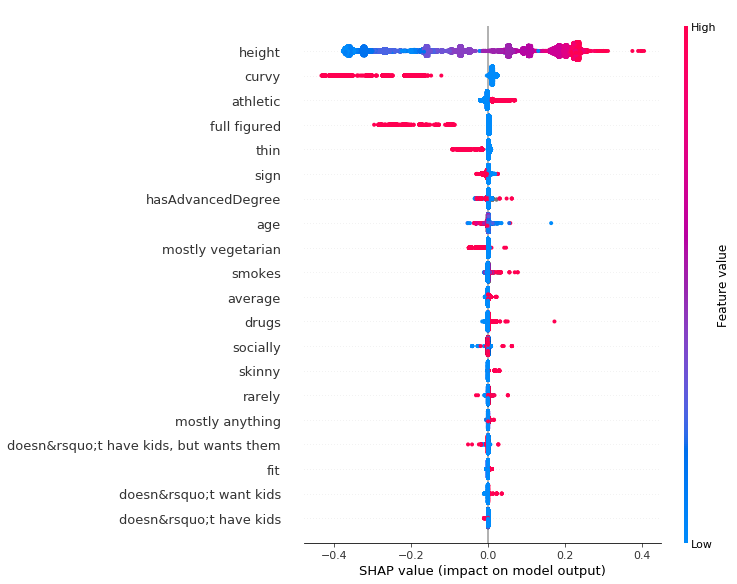

In [22]:
shap.summary_plot(shap_values, X_train)

In [25]:
shap.force_plot(explainer.expected_value, shap_values[:1000], X_train[:1000])

In [24]:
X_train[:1000]

,age,drugs,height,sign,smokes,a little extra,athletic,average,curvy,fit,...,"has a kid, and might want more","has a kid, and wants more","has a kid, but doesn&rsquo;t want more",has kids,"has kids, and might want more","has kids, and wants more","has kids, but doesn&rsquo;t want more",might want kids,wants kids,hasAdvancedDegree
26306,29,0.0,70.0,1.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
54877,26,0.0,70.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
6457,31,0.0,70.0,0.0,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0
53327,37,0.0,67.0,1.0,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.0
27747,44,0.0,68.0,1.0,1.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0
42403,32,0.0,64.0,1.0,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0
19089,33,0.0,65.0,0.0,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0
54876,26,0.0,75.0,1.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
16790,24,0.0,71.0,1.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4623,37,0.0,68.0,0.0,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.0


## Train New Models

In [ ]:
X = df2 
y = df.sex.apply(lambda x: 1 if x == 'm' else 0)

In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mean.fit(X)

X = imp_mean.transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(min_samples_split=4)

clf.fit(X_train, y_train)

pred = clf.predict(X_test)
accuracy_score(pred, y_test)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
xgboost = GradientBoostingClassifier()
xgboost.fit(X_train, y_train)
pred = xgboost.predict(X_test)
accuracy_score(pred, y_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knnc = KNeighborsClassifier()
knnc.fit(X_train, y_train)
pred = knnc.predict(X_test)
accuracy_score(pred, y_test)